### 1. Импорт всех нужных инструментов ### 

In [46]:
!pip install pymorphy2

    100% |████████████████████████████████| 51kB 648kB/s 
  Using cached https://files.pythonhosted.org/packages/6a/84/ff1ce2071d4c650ec85745766c0047ccc3b5036f1d03559fd46bb38b5eeb/DAWG_Python-0.7.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a2/55/8f8cab2afd404cf578136ef2cc5dfb50baa1761b68c9da1fb1e4eed343c9/docopt-0.6.2.tar.gz
    100% |████████████████████████████████| 7.1MB 89kB/s 
  Running setup.py bdist_wheel for docopt ... - \ | done
  Stored in directory: /home/anna/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
Successfully built docopt
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import wordpunct_tokenize
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline  
pd.set_option('max_colwidth', 1000)

### 2. Загрузка данных ###

In [103]:
train_df = pd.read_csv('data/sentiment_twitter/train_sentiment_ttk.tsv', sep='\t', encoding='utf-8')
test_df = pd.read_csv('data/sentiment_twitter/test_sentiment_ttk.tsv', sep='\t', encoding='utf-8')

In [104]:
train_df.head(5)

,label,text
0,0,"@mkomov Максим, Вашем письмо мы получили. Наши сотрудники свяжутся с Вами завтра и направят запрос инженерам для проверки. #билайн"
1,0,«Мегафон» стал владельцем 50% акций «Евросети»
2,-1,"RT @fuckkiev: “@EvaKobb: МТС Россия прислала жителям Херсонщины сообщения, в которых обозвала украинцев фашистами? http://t.co/RbSesXlOUZ” …"
3,1,ВИДЕО: http://t.co/PSMLAhR4fI Реклама со смехом МТС - Супер 0
4,-1,"@parfenov1960 потому что МТС достало, а пчел ненавижу с детства, как и их мёд!"


In [105]:
test_df.head(5)

,label,text
0,-1,RT vzglyad: По делу о работе МТС в Узбекистане США предложили заморозить 300 млн
1,0,RT @kevinuyatukox: http://t.co/ljtrjq91v3 #Кредитные карты мегафон банка
2,0,#Оформить кредитную карту в банке мтс http://t.co/vv1B6PMWgH
3,0,#Как перевести деньги с билайна на кредитную карту
4,0,#Начальник отдела кредитного контроля оао мтс усачева н а


In [106]:
X_train, X_test = train_df['text'], test_df['text']
y_train, y_test = train_df['label'], test_df['label']

### 3. Baseline ###

Попробуем натренировать логистическую регрессию с дефолтными параметрами (кроме penalty, тут возьмем значение 'l1') на ненормализованных данных, используя CountVectorizer и TfidfVectorizer - также с дефолтными параметрами.

In [125]:
def train_and_report(X_train, y_train, X_test, y_test, alg, vectorizer):
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    alg.fit(X_train_vec, y_train)

    y_pred = alg.predict(X_test_vec)
    
    print(classification_report(y_test, y_pred))
    print("Макросредняя F1 мера - ", f1_score(y_test, y_pred, average="macro"))
    print("Микросредняя F1 мера - ", f1_score(y_test, y_pred, average="micro"))
    
    labels = alg.classes_
    fig, ax = plt.subplots(figsize=(10,5))
    sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, 
                fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
    plt.title("Confusion matrix")
    plt.show()

In [126]:
def print_important(vectorizer, clf, topn=10):
    features = vectorizer.get_feature_names()
    classes = clf.classes_
    importances = clf.coef_
    for i, cls in enumerate(classes):
        print('Значимые слова для класса - ', cls)
        important_words = sorted(list(zip(features, importances[i])), key=lambda x: abs(x[1]), reverse=True)[:topn]
        print([word for word,_ in important_words])
        print()

#### 3.1 Count Vectorizer ####

Classification report: baseline-logistic regression + count vectorizer

             precision    recall  f1-score   support

         -1       0.74      0.66      0.70       902
          0       0.67      0.78      0.72       972
          1       0.40      0.26      0.31       180

avg / total       0.68      0.68      0.68      2054

Макросредняя F1 мера -  0.578306045814
Микросредняя F1 мера -  0.684031158715


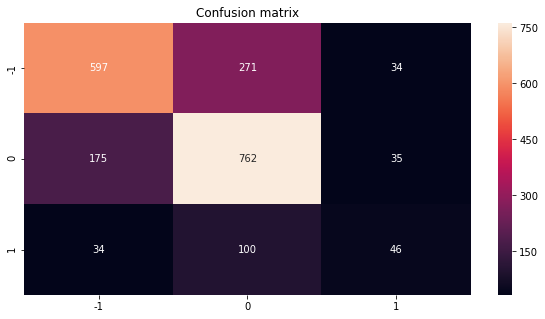

In [162]:
cv_vect = CountVectorizer()
lr = LogisticRegression(penalty='l1')

print('Classification report: baseline-logistic regression + count vectorizer\n')
train_and_report(X_train, y_train, X_test, y_test, lr, cv_vect)

In [163]:
print_important(cv_vect, lr)

Значимые слова для класса -  -1
['сбой', 'собираются', 'перебоями', 'говно', 'обратилась', 'tele2', 'оштрафовать', 'сука', 'гавно', 'аду']

Значимые слова для класса -  0
['собираются', 'обратилась', 'иа', 'сбой', 'жителям', 'границы', 'гавно', 'просит', 'меры', 'люблю']

Значимые слова для класса -  1
['люблю', 'обожаю', 'специалистом', 'ожидал', 'здорово', 'выросла', 'мило', 'новогоднее', 'защиту', 'расширяется']



#### 3.2 Tf-idf Vectorizer ####

Classification report: baseline-logistic regression + tf-idf vectorizer

             precision    recall  f1-score   support

         -1       0.70      0.69      0.70       902
          0       0.66      0.76      0.71       972
          1       0.37      0.09      0.15       180

avg / total       0.65      0.67      0.65      2054

Макросредняя F1 мера -  0.517951914088
Микросредняя F1 мера -  0.671859785784


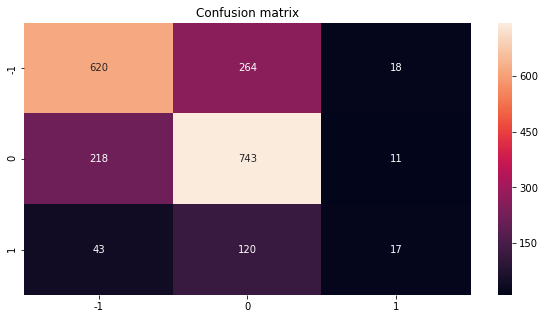

In [164]:
tfidf_vect = TfidfVectorizer()
lr = LogisticRegression(penalty='l1')

print('Classification report: baseline-logistic regression + tf-idf vectorizer\n')
train_and_report(X_train, y_train, X_test, y_test, lr, tfidf_vect)

In [165]:
print_important(tfidf_vect, lr)

Значимые слова для класса -  -1
['сбой', 'tele2', 'старые', 'не', 'сука', 'говно', 'просит', 'проблемы', 'крыму', 'фас']

Значимые слова для класса -  0
['иа', 'просит', 'сбой', 'гонконгские', 'цены', 'границы', 'пожалуйста', 'сн', 'связь', 'ловит']

Значимые слова для класса -  1
['люблю', 'узбекистан', 'спасибо', 'расходы', 'пожалуйста', 'подарок', 'клиенты', 'бесплатный', 'увеличил', 'защиты']



#### 3.3 Некоторые выводы ####
По матрицам видно, что больше всего проблем вызывает класс 0: алгоритм очень часто путает нейтральные твиты с отрицательными, реже - с положительными, тогда как путаница между отрицательными и положительными твитами встречается гораздо реже.

CountVectorizer выделил более адекватные значимые признаки. У класса -1 признаки достаточно яркие за исключением "собираются", "обратилась" (хотя обращаются обычно с проблемами, так что...) и "tele2" (видимо, в датасете было много негативных отзывов о работе этой компании). У Tfidf мусора больше: "не", "просит", "крыму" и "фас" кажутся совсем неважными для определения тональности признаками. Аналогично с классом 1: у Tfidf явно совсем лишние "узбекистан", "расходы", "клиенты", у CV вызывают вопросы "специалистом" и "расширяются".
 
Становится понятно, почему класс 0 всем мешает: некоторые значимые признаки этого класса совпадают с чужими значимыми признаками ("говно"/"гавно", "просит", "пожалуйста", "сбой".

В целом, видно, что CountVectorizer справился с задачей выделений признаков лучше.

### 4. Нормализация текстов ###

На этом этапе:

1. Удалим из твитов все юзернеймы и ссылки.

2. Токенизируем, используя инструмент NLTK.

3. Лемматизируем, используя pymorphy2 (потому что это быстрее, чем майстем), выкинув пунктуацию, стоп-слова по данным NLTK и лемму 'rt', которая появляется в твите, когда кто-то кого-то ретвитит.

In [133]:
def normalize(text):
    morph = MorphAnalyzer()
    stops = stopwords.words('russian')
    punct = string.punctuation + '«»“”—…'
    
    text = text.lower()
    text = re.sub(r'https?:\/\/?.*? ', '', text)
    text = re.sub(r'@([A-Za-z0-9_]+)', '', text)
    
    tokens = wordpunct_tokenize(text)
    all_lemmas = [morph.parse(token)[0].normal_form for token in tokens]
    
    cleaned_lemmas = [lemma for lemma in all_lemmas if lemma not in stops 
                      and lemma not in punct and lemma != 'rt']
    
    return ' '.join(cleaned_lemmas)

In [134]:
X_train_norm = train_df['text'].apply(normalize)
X_test_norm  = test_df['text'].apply(normalize)

In [166]:
X_train_norm.head(5)

0    максим ваш письмо получить наш сотрудник связаться завтра направить запрос инженер проверка билайн
1                                                              мегафон стать владелец 50 акция евросеть
2                   “: мтс россия прислать житель херсонщина сообщение который обозвать украинец фашист
3                                                                        видео реклама смех мтс супер 0
4                                                              мтс достать пчела ненавидеть детство мёд
Name: text, dtype: object

### 6. Baseline-алгоритм на почищенных данных ###

Теперь опробуем логрег и векторайзеры с дефолтными параметрами на почищенных данных и посмотрим, изменилось ли что-то.

             precision    recall  f1-score   support

         -1       0.73      0.59      0.65       902
          0       0.64      0.80      0.71       972
          1       0.44      0.27      0.34       180

avg / total       0.66      0.66      0.65      2054

Макросредняя F1 мера -  0.564659634996
Микросредняя F1 мера -  0.658714703019


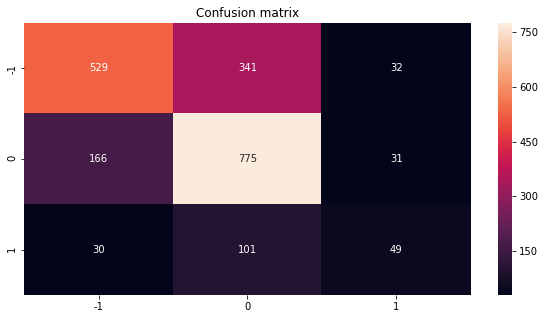

In [172]:
train_and_report(X_train_norm, y_train, X_test_norm, y_test, lr, cv_vect)

In [173]:
print_important(cv_vect, lr)

Значимые слова для класса -  -1
['расти', 'оштрафовать', 'задолженность', 'говно', 'восстановление', 'tele2', 'сбой', 'жопа', 'гавный', 'pomogite']

Значимые слова для класса -  0
['восстановление', 'оштрафовать', 'задолженность', 'иа', 'гавный', 'говно', 'ловить', 'вспомнить', 'экскурсия', 'заебал']

Значимые слова для класса -  1
['защита', 'понравиться', 'инноватор', 'благодарить', 'поезд', 'расширяться', 'любить', 'ереван', 'мило', 'болтать']



             precision    recall  f1-score   support

         -1       0.72      0.52      0.60       902
          0       0.60      0.82      0.69       972
          1       0.40      0.16      0.23       180

avg / total       0.63      0.63      0.61      2054

Макросредняя F1 мера -  0.508816830768
Микросредняя F1 мера -  0.630963972736


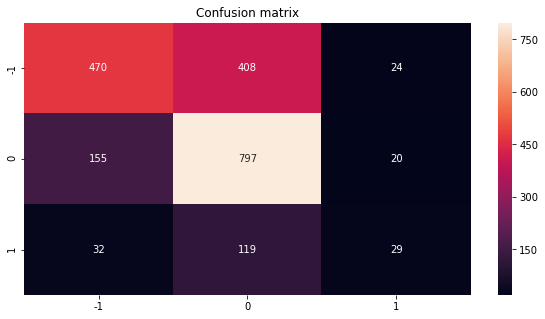

In [174]:
train_and_report(X_train_norm, y_train, X_test_norm, y_test, lr, tfidf_vect)

In [175]:
print_important(tfidf_vect, lr)

Значимые слова для класса -  -1
['tele2', 'оштрафовать', 'восстановление', 'сбой', 'говно', 'организовать', 'http', 'лежать', 'подорожать', 'сук']

Значимые слова для класса -  0
['доллар', 'восстановление', 'иа', 'оштрафовать', 'инструкция', 'ловить', 'донецк', 'экскурсия', 'создание', 'сн']

Значимые слова для класса -  1
['защита', 'получать', 'понравиться', 'подарок', 'любить', 'узбекистан', 'расход', 'доллар', 'бесплатный', 'хороший']



### 7. Подбор параметров ###

Теперь подберем параметры векторайзеров и логрега. Для логрега будем перебирать параметры 'penalty' и 'C', для векторайзеров - 'ngram_range' и 'max_df'.

In [146]:
full_X = X_train_norm.append(X_test_norm)
full_y = y_train.append(y_test)

In [147]:
def find_best_params(X, y, pipeline, params):
    grid = GridSearchCV(pipeline, params, scoring='accuracy', cv=5)
    grid.fit(X, y)
    
    print("Best score: %s" % grid.best_score_)
    print("Best parameters set:")
    
    best_parameters = grid.best_estimator_.get_params()
    
    for param in sorted(params.keys()):
        print("\t%s: %s" % (param, best_parameters[param]))

In [152]:
pipeline = Pipeline([('cv_vect', CountVectorizer()), ('lr', LogisticRegression(random_state=42))])
params = {'cv_vect__max_df': (0.5, 0.75, 1.0), 'cv_vect__ngram_range': ((1, 1), (1, 2)),
          'lr__penalty': ['l1', 'l2'], 'lr__C': [0.01, 0.1, 1, 10, 100]}

find_best_params(full_X, full_y, pipeline, params)

Best score: 0.707269538102
Best parameters set:
	cv_vect__max_df: 0.5
	cv_vect__ngram_range: (1, 2)
	lr__C: 100
	lr__penalty: l2


In [153]:
pipeline = Pipeline([('tfidf_vect', TfidfVectorizer()), ('lr', LogisticRegression(random_state=42))])
params = {'tfidf_vect__max_df': (0.5, 0.75, 1.0), 'tfidf_vect__ngram_range': ((1, 1), (1, 2)),
          'lr__penalty': ['l1', 'l2'], 'lr__C': [0.01, 0.1, 1, 10, 100]}

find_best_params(full_X, full_y, pipeline, params)

Best score: 0.709803157279
Best parameters set:
	lr__C: 10
	lr__penalty: l2
	tfidf_vect__max_df: 0.5
	tfidf_vect__ngram_range: (1, 2)


Лучше всего сработала комбинация tfidf с max_df=0.5 и ngram_range=(1, 2) + логрег с C=10, penalty=l2.

### 8. Обучение лучшего алгоритма ###

             precision    recall  f1-score   support

         -1       0.75      0.63      0.69       902
          0       0.66      0.82      0.73       972
          1       0.43      0.21      0.28       180

avg / total       0.68      0.68      0.67      2054

Макросредняя F1 мера -  0.567284034567
Микросредняя F1 мера -  0.684518013632


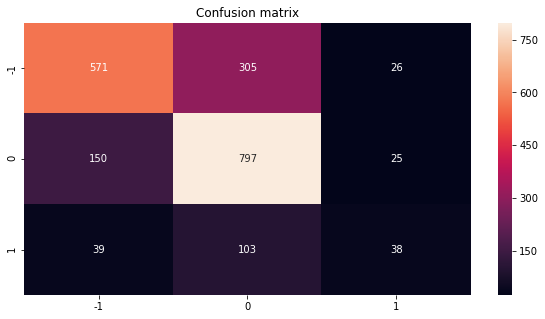

In [169]:
best_vect = TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))
best_lr = LogisticRegression(penalty='l2', C=10)

train_and_report(X_train_norm, y_train, X_test_norm, y_test, best_lr, best_vect)

In [170]:
print_important(best_vect, best_lr)

Значимые слова для класса -  -1
['tele2', 'говно', 'почему', 'крым', 'сук', 'ловить', 'спасибо', 'связь', 'отключить', 'инструкция']

Значимые слова для класса -  0
['ловить', 'здравствовать', 'инструкция', 'почему', 'говно', 'настройка', 'работать', 'связь', 'телефон', 'весь работать']

Значимые слова для класса -  1
['любить', 'узбекистан', 'хороший', 'бесплатный', 'заработать', 'защита', 'подарок', 'ура', 'мило', 'приятно']



На всякий случай обучим лучший алгоритм на ненормализованных данных.

             precision    recall  f1-score   support

         -1       0.70      0.75      0.72       902
          0       0.69      0.73      0.71       972
          1       0.50      0.15      0.23       180

avg / total       0.68      0.69      0.68      2054

Макросредняя F1 мера -  0.556130858592
Микросредняя F1 мера -  0.690847127556


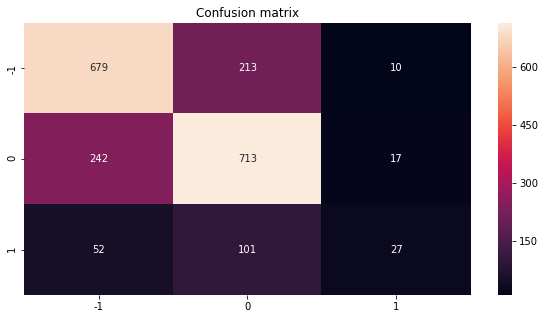

In [171]:
train_and_report(X_train, y_train, X_test, y_test, best_lr, best_vect)

In [176]:
print_important(best_vect, best_lr)

Значимые слова для класса -  -1
['не', 'нет', 'tele2', 'крыму', 'не работает', 'сука', 'говно', 'связь', 'спасибо', 'опять']

Значимые слова для класса -  0
['связь', 'для', 'не', 'здравствуйте', 'пожалуйста', 'beeline_rus', 'даже', 'ловит', 'нет', 'номер']

Значимые слова для класса -  1
['спасибо', 'люблю', 'не', 'lte', '4g', 'узбекистан', 'области', 'теперь', 'beeline_rus', 'заработал']



Качество обучения на нормализованных данных выросло, но при этом не превзошло бэйзлайн. Лучшее качество получается при обучении алгоритма с лучшими параметрами на ненормализованных данных.

Нормализация никак не решила проблему мешающего класса 0 и смешивания значимых признаков. Интересно, что в случае лучшего качества классификации выделяются с виду наиболее "замусоренные" значимые признаки. 

Посмотрим на ошибочно классифицированные твиты.

In [191]:
print(X_test[8])

RT @vishtorskayaa: Отказано в доступе при установки драйвера модема мегафон #установки #модема


Этот твит относится к классу -1, но был отнесен к классу 0. Это в целом логично, потому что в твите нет ярких негативно окрашенных слов, кроме, может быть, "отказано.

In [188]:
print(X_test[12])

@adagamov @megafonru вы как Сбербанк 2.0, когда центральный офис не знает что делает подчиненный, надо куда то ходить, звонить.


Этот твит относится к классу -1, но был отнесен к классу 1. Тут вообще сложно уцепиться за что-то, лексика достаточно нейтральная. Возможно, улучшить качество классификации в таких случаях помогло бы увеличение ngram_range.

### 9. Общий вывод и таблица ###

Возможно, улучшить качество классификации помогло бы использование другого алгоритма (может быть, SVM или Random Forest) и вычищение значимых признаков, совпадающих у разных классов.

|      | С нормализацией | Без нормализации |
|------|------|----------|------------------|
|   baseline + cv  | 0.684 | 0.659 |
|baseline + tfidf | 0.672 | 0.631 |
| tuned logreg (tfidf) | 0.685 | 0.691 |